In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install --upgrade pip
!pip install TensorFlow
import sys
import os
import json
import pandas
import numpy
import optparse
!pip install keras --upgrade
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
data = pd.read_csv("finalData.csv")
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,avgTemp
0,"Chicago,United States",2012-05-01,17.9,11.0,14.6,17.9,11.0,14.6,11.2,80.3,...,6,NaN,2012-05-01T05:46:04,2012-05-01T19:49:44,0.35,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",14.45
1,"Chicago,United States",2012-05-02,25.9,14.7,21.0,25.9,14.7,21.0,15.3,71.9,...,6,NaN,2012-05-02T05:44:46,2012-05-02T19:50:49,0.38,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",20.30
2,"Chicago,United States",2012-05-03,29.3,20.4,24.8,30.2,20.4,25.2,18.0,66.8,...,5,NaN,2012-05-03T05:43:28,2012-05-03T19:51:54,0.42,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",24.85
3,"Chicago,United States",2012-05-04,22.7,11.9,17.3,22.7,11.9,17.3,13.6,79.0,...,5,NaN,2012-05-04T05:42:13,2012-05-04T19:52:59,0.45,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",17.30
4,"Chicago,United States",2012-05-05,15.7,12.4,13.8,15.7,12.4,13.8,11.4,85.9,...,8,NaN,2012-05-05T05:40:58,2012-05-05T19:54:04,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,...",14.05


In [3]:
data = data[["datetime","tempmax","tempmin","temp"]]
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by="datetime", inplace=True)
data_tmax = data[["datetime","tempmax"]]
data_tmin = data[["datetime","tempmin"]]
data_tavg = data[["datetime","temp"]]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4018 entries, 0 to 4017
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  4018 non-null   datetime64[ns]
 1   tempmax   4018 non-null   float64       
 2   tempmin   4018 non-null   float64       
 3   temp      4018 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 157.0 KB


In [5]:
data.head()

,datetime,tempmax,tempmin,temp
0,2012-05-01,17.9,11.0,14.6
1,2012-05-02,25.9,14.7,21.0
2,2012-05-03,29.3,20.4,24.8
3,2012-05-04,22.7,11.9,17.3
4,2012-05-05,15.7,12.4,13.8


In [6]:
data.tail()

,datetime,tempmax,tempmin,temp
4013,2023-04-27,18.8,3.4,10.8
4014,2023-04-28,15.9,8.7,12.0
4015,2023-04-29,13.9,6.2,10.1
4016,2023-04-30,8.2,4.6,6.6
4017,2023-05-01,9.9,4.8,6.7


In [7]:
data.isnull().sum()

datetime    0
tempmax     0
tempmin     0
temp        0
dtype: int64

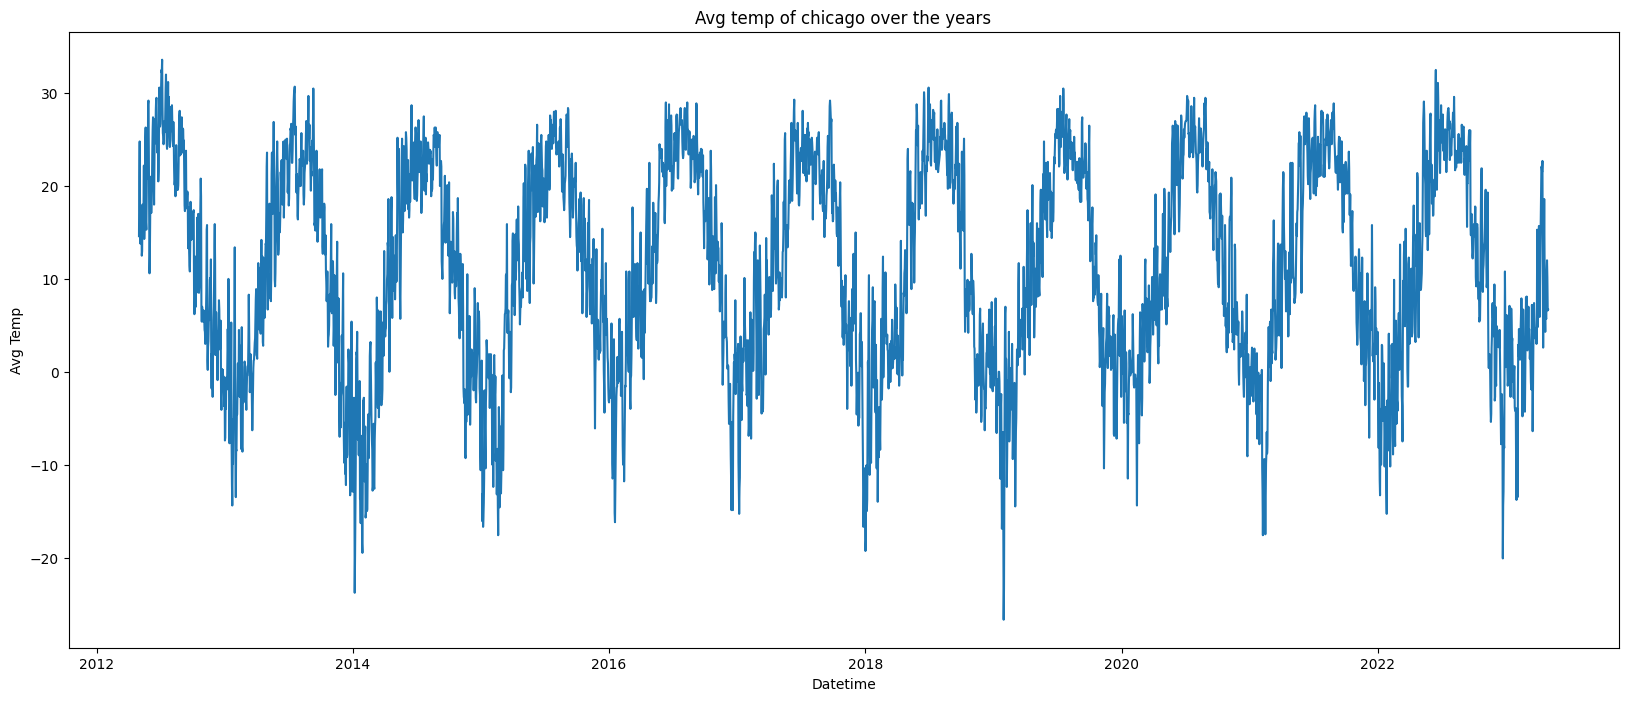

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['temp'])
plt.xlabel('Datetime')
plt.ylabel('Avg Temp')
plt.title('Avg temp of chicago over the years')
plt.show()

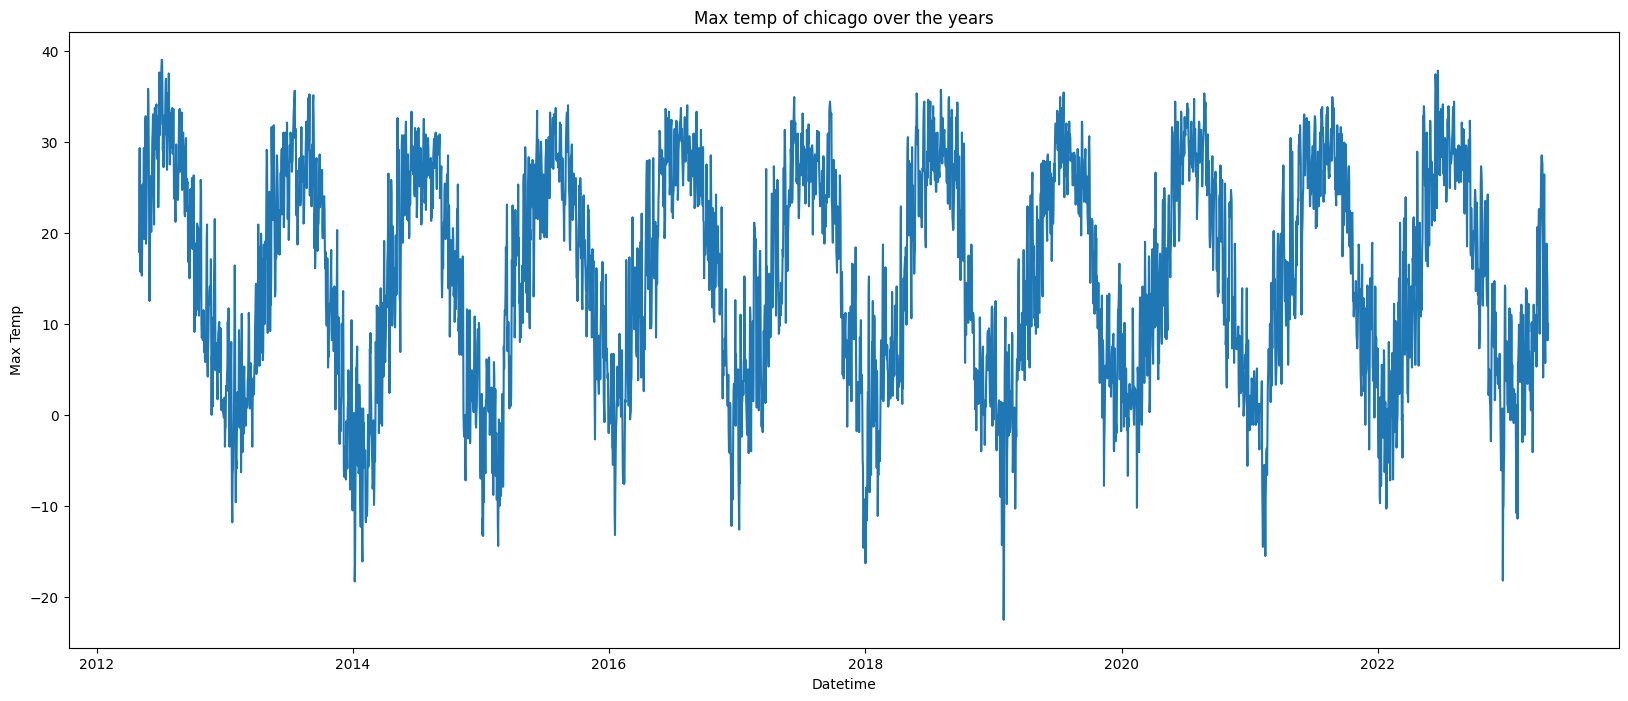

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['tempmax'])
plt.xlabel('Datetime')
plt.ylabel('Max Temp')
plt.title('Max temp of chicago over the years')
plt.show()

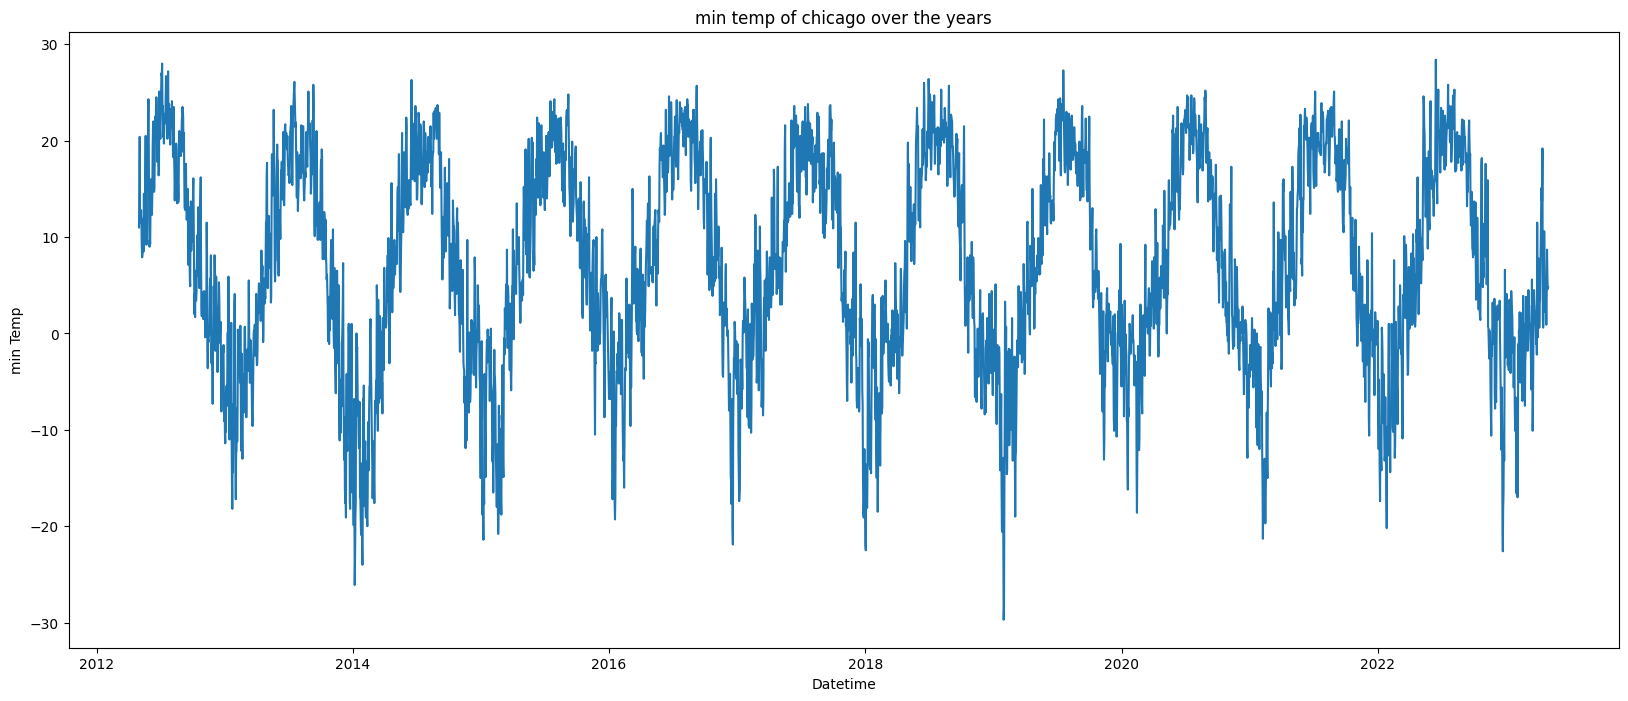

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['tempmin'])
plt.xlabel('Datetime')
plt.ylabel('min Temp')
plt.title('min temp of chicago over the years')
plt.show()

In [11]:
from typing import Tuple
def create_data_for_NN(data: pandas.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    y = data[Y_var].tolist()
    X, Y = [], []
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])
    
    X, Y = np.array(X), np.array(Y)
    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Creating training and test sets
    X_train = X
    X_test = []
    Y_train = Y
    Y_test = []
    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]
        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]
    return X_train, X_test, Y_train, Y_test

In [12]:
from sklearn.preprocessing import StandardScaler
def scale_values(X_train, X_test, Y_train, Y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    scaler = StandardScaler()
    Y_train_scaled = scaler.fit_transform(Y_train.reshape(-1, 1)).reshape(Y_train.shape)
    Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)
    return X_train_scaled,X_test_scaled,Y_train_scaled,Y_test_scaled

In [13]:
lag = 3
test_ratio = 0.25
X_train, X_test, Y_train, Y_test = create_data_for_NN(data_tavg, data_tavg.columns[-1], lag, test_ratio)
X_train_scaled,X_test_scaled,Y_train_scaled,Y_test_scaled = scale_values(X_train, X_test, Y_train, Y_test)

In [14]:
model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(1))

model1.compile(loss='mean_squared_error', optimizer='adam',metrics="mean_squared_error")

model1.fit(X_train_scaled, Y_train_scaled, validation_split = 0.25,  epochs=3, batch_size=72)

Epoch 1/3
32/32 [==============================] - 8s 51ms/step - loss: 0.6142 - mean_squared_error: 0.6142 - val_loss: 0.2704 - val_mean_squared_error: 0.2704
Epoch 2/3
32/32 [==============================] - 0s 13ms/step - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.1540 - val_mean_squared_error: 0.1540
Epoch 3/3
32/32 [==============================] - 0s 12ms/step - loss: 0.1731 - mean_squared_error: 0.1731 - val_loss: 0.1466 - val_mean_squared_error: 0.1466


In [15]:
from sklearn.metrics import mean_squared_error

pred1 = model1.predict(X_test_scaled)
rmse1 = np.sqrt(mean_squared_error(Y_test_scaled, pred1))


32/32 [==============================] - 1s 5ms/step


In [16]:
print("RMSE for single layer, lag = 3 - ",rmse1)

RMSE for single layer, lag = 3 -  0.40419134766230813


In [17]:
test = pd.read_csv("Chicago,United States 2023-05-02 to 2023-05-15.csv")

In [18]:
tdata = test[["datetime","tempmax","tempmin","temp"]]
tdata['datetime'] = pd.to_datetime(tdata['datetime'])
tdata.sort_values(by="datetime", inplace=True)
tdata_tmax = tdata[["datetime","tempmax"]]
tdata_tmin = tdata[["datetime","tempmin"]]
tdata_tavg = tdata[["datetime","temp"]]

<ipython-input-18-95b3ae363efa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['datetime'] = pd.to_datetime(tdata['datetime'])
<ipython-input-18-95b3ae363efa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.sort_values(by="datetime", inplace=True)


In [19]:
def create_tdata_for_NN(data: pandas.DataFrame, Y_var: str, lag: int) -> Tuple[np.array, np.array, np.array]:
    y = data[Y_var].tolist()
    X, Y = [], []
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])
    
    X, Y = np.array(X), np.array(Y)
    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Creating training and test sets
    """X_train = X
    X_test = []
    Y_train = Y
    Y_test = []
    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]
        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]"""
    return X, Y

In [20]:
def scale_tvalues(X,Y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    #X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y.reshape(-1, 1)).reshape(Y.shape)
    #Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)
    return X_scaled, Y_scaled

In [21]:
lag = 3
#test_ratio = 0.25
X,Y = create_tdata_for_NN(tdata_tavg, tdata_tavg.columns[-1], lag)
X_scaled, Y_scaled = scale_tvalues(X,Y)

In [22]:
X

array([[[ 8.9],
        [ 8.7],
        [14.1]],

       [[ 8.7],
        [14.1],
        [19.7]],

       [[14.1],
        [19.7],
        [19.9]],

       [[19.7],
        [19.9],
        [21.4]],

       [[19.9],
        [21.4],
        [12.6]],

       [[21.4],
        [12.6],
        [14.9]],

       [[12.6],
        [14.9],
        [18. ]],

       [[14.9],
        [18. ],
        [21. ]],

       [[18. ],
        [21. ],
        [20.2]],

       [[21. ],
        [20.2],
        [16.1]],

       [[20.2],
        [16.1],
        [14.9]]])

In [23]:
predf = model1.predict(X)
rmsef = np.sqrt(mean_squared_error(Y, predf))

1/1 [==============================] - 0s 51ms/step


In [24]:
rmsef

14.74706622003812

In [25]:
predf

array([[3.2017417],
       [3.0135021],
       [3.0732589],
       [3.0592942],
       [3.3478148],
       [3.3465233],
       [3.1487288],
       [3.0627031],
       [3.076911 ],
       [3.2206583],
       [3.3065279]], dtype=float32)

In [26]:
predf = scaler.inverse_transform(predf)


NameError: ignored